## TODO
- Consider these columns comparing with -1M and -2M:
    > num_25, num_50, num_75, num_985, num_100, num_unq

- Remove these columns:
    - is_cancel
    - is_active
    - payment_plan_days

- Data prep:
    - Left join users table
        - If the user information is none, copy info from last / next available month!

In [1006]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1007]:
from Utils.DataLoader import DataLoader
from Utils.DataTransformer import DataTransformer
from Utils.DuckDb.DuckDb import DuckDb
from Utils.DatasetProcessor.DatasetProcessorUtils import DatasetProcessorUtils
from datetime import datetime
import pandas as pd
from typing import List
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from Utils import PandasNotebookConfigs

# Importing all the tools we need

# Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If matplotlib plots don't work, uncomment this line
# %matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [1008]:
PandasNotebookConfigs.config()

Ajustando display.float.format para %.4f


In [1009]:
DUCK_DB_UTILS = DuckDb()
DATA_TRANSFORMER = DataTransformer()
DATA_PROCESSOR_UTILS = DatasetProcessorUtils()

In [1010]:
TABLE_NAME = 'treated_churn_dataset_2025_03_13_15h03m' # Best Dataset - 14/03/2025
TABLE_NAME = 'treated_churn_dataset_2025_03_15_08h55m' # Last processed dataset after changes on 14/03/2025
TABLE_NAME = 'treated_churn_dataset_2025_03_16_12h04m' # Last processed dataset to test after churn logic change (16/03/2025)

In [1011]:
df = DUCK_DB_UTILS.load_table(TABLE_NAME, limit = 500_000)

In [1012]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [1013]:
len(df)

500000

In [1014]:
def calc_remaining_time(df: pd.DataFrame) -> pd.DataFrame:
    result = []
    for _, row in df.iterrows():
        transaction_date = datetime(row['transaction_date_year'], row['transaction_date_month'], row['transaction_date_day'])
        member_expire_date = datetime(row['membership_expire_date_year'], row['membership_expire_date_month'], row['membership_expire_date_day'])

        diff = (transaction_date - member_expire_date).total_seconds() / 24 / 60 / 60
        result.append(abs(diff))

    return result

df['remaining_days'] = calc_remaining_time(df)

In [1015]:
df

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days
0,57.8172,+pFjoKkTTiQ3EE/AAvHd6uMkL4EfDjKQkyQIOKSktDA=,201611,22,9,7,8,250,280,63892,...,25.0000,27.0000,12.0000,21.0000,7.0000,17.0000,4.0000,913.0000,765.0000,30.0000
1,63.8663,/YnITTaGIu9lKoiV7NMEra5jlX9CT/I3gr4plQx0nFM=,201611,125,28,21,20,390,501,113112,...,148.0000,25.0000,16.0000,15.0000,13.0000,28.0000,22.0000,289.0000,254.0000,29.0000
2,101.1025,/5BnOLsk6ox5eHoDou9PhFHYF7j5AAYM83vOQXjw1GA=,201601,87,13,5,13,1923,1613,428762,...,89.0000,14.0000,8.0000,13.0000,12.0000,10.0000,16.0000,1789.0000,1517.0000,31.0000
3,56.8954,/1g0nSdVpidzhw5lZHNV5s8JP+1ZTZSBoqIDCIb1hCM=,201611,38,4,7,4,226,243,56561,...,20.0000,3.0000,5.0000,1.0000,5.0000,1.0000,5.0000,51.0000,98.0000,30.0000
4,51.0940,1Cnfc/+XZZGjiup3l/jnxNFzfz6ixfxijG6FAQTlWtw=,201611,5,1,0,0,34,37,9053,...,7.0000,0.0000,1.0000,0.0000,0.0000,0.0000,4.0000,14.0000,37.0000,30.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,56.2200,01ETD+LUIXiCuZGu4//jTw4cBBCLCIIedlYYIV+MlNU=,201608,107,26,16,10,158,283,47767,...,208.0000,84.0000,64.0000,58.0000,38.0000,59.0000,20.0000,632.0000,446.0000,36.0000
499996,50.1844,0t7TR1XiPVIVVuv09w5EM4dB2fp0JSc7vm6Z1Xt9L3I=,201607,0,0,1,1,5,7,1487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0000
499997,87.3780,/1FRCPXbo01QQNHMkvea/IELVfBlr0LQJpbjxbfjm0U=,201606,107,24,18,31,1260,842,330838,...,149.0000,12.0000,32.0000,10.0000,30.0000,8.0000,40.0000,651.0000,1458.0000,54.0000
499998,57.3933,/8XFme+h4W5esqW0krJ4ULHGwaF+c2bXcRmPL7tLOoY=,201607,105,49,41,27,161,314,57919,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0000


In [1016]:
# Treating DF
df.isna().sum().T

cost                                       0
msno                                       0
safra                                      0
num_25                                     0
num_50                                     0
num_75                                     0
num_985                                    0
num_100                                    0
num_unq                                    0
total_secs                                 0
total_hours                                0
msno_1                                     0
payment_method_id                          0
payment_plan_days                          0
plan_list_price                            0
actual_amount_paid                         0
is_auto_renew                              0
is_cancel                                  0
safra_1                                    0
transaction_date_year                      0
transaction_date_month                     0
transaction_date_day                       0
transactio

In [1017]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days
0,57.8172,+pFjoKkTTiQ3EE/AAvHd6uMkL4EfDjKQkyQIOKSktDA=,201611,22,9,7,8,250,280,63892,...,25.0000,27.0000,12.0000,21.0000,7.0000,17.0000,4.0000,913.0000,765.0000,30.0000
1,63.8663,/YnITTaGIu9lKoiV7NMEra5jlX9CT/I3gr4plQx0nFM=,201611,125,28,21,20,390,501,113112,...,148.0000,25.0000,16.0000,15.0000,13.0000,28.0000,22.0000,289.0000,254.0000,29.0000
2,101.1025,/5BnOLsk6ox5eHoDou9PhFHYF7j5AAYM83vOQXjw1GA=,201601,87,13,5,13,1923,1613,428762,...,89.0000,14.0000,8.0000,13.0000,12.0000,10.0000,16.0000,1789.0000,1517.0000,31.0000
3,56.8954,/1g0nSdVpidzhw5lZHNV5s8JP+1ZTZSBoqIDCIb1hCM=,201611,38,4,7,4,226,243,56561,...,20.0000,3.0000,5.0000,1.0000,5.0000,1.0000,5.0000,51.0000,98.0000,30.0000
4,51.0940,1Cnfc/+XZZGjiup3l/jnxNFzfz6ixfxijG6FAQTlWtw=,201611,5,1,0,0,34,37,9053,...,7.0000,0.0000,1.0000,0.0000,0.0000,0.0000,4.0000,14.0000,37.0000,30.0000


In [1018]:
len(df)

500000

In [1019]:
# Feature engineering
df['safra_year'] = df['safra'].astype(str).str[:4].astype(float)
df['safra_month'] = df['safra'].astype(str).str[-2:].astype(float)
df = df.drop('safra', axis=1)

In [1020]:
df.head()

,cost,msno,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,...,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days,safra_year,safra_month
0,57.8172,+pFjoKkTTiQ3EE/AAvHd6uMkL4EfDjKQkyQIOKSktDA=,22,9,7,8,250,280,63892,17.7478,...,12.0000,21.0000,7.0000,17.0000,4.0000,913.0000,765.0000,30.0000,2016.0000,11.0000
1,63.8663,/YnITTaGIu9lKoiV7NMEra5jlX9CT/I3gr4plQx0nFM=,125,28,21,20,390,501,113112,31.4200,...,16.0000,15.0000,13.0000,28.0000,22.0000,289.0000,254.0000,29.0000,2016.0000,11.0000
2,101.1025,/5BnOLsk6ox5eHoDou9PhFHYF7j5AAYM83vOQXjw1GA=,87,13,5,13,1923,1613,428762,119.1006,...,8.0000,13.0000,12.0000,10.0000,16.0000,1789.0000,1517.0000,31.0000,2016.0000,1.0000
3,56.8954,/1g0nSdVpidzhw5lZHNV5s8JP+1ZTZSBoqIDCIb1hCM=,38,4,7,4,226,243,56561,15.7114,...,5.0000,1.0000,5.0000,1.0000,5.0000,51.0000,98.0000,30.0000,2016.0000,11.0000
4,51.0940,1Cnfc/+XZZGjiup3l/jnxNFzfz6ixfxijG6FAQTlWtw=,5,1,0,0,34,37,9053,2.5147,...,1.0000,0.0000,0.0000,0.0000,4.0000,14.0000,37.0000,30.0000,2016.0000,11.0000


In [1021]:
df.isna().sum().T

cost                                       0
msno                                       0
num_25                                     0
num_50                                     0
num_75                                     0
num_985                                    0
num_100                                    0
num_unq                                    0
total_secs                                 0
total_hours                                0
msno_1                                     0
payment_method_id                          0
payment_plan_days                          0
plan_list_price                            0
actual_amount_paid                         0
is_auto_renew                              0
is_cancel                                  0
safra_1                                    0
transaction_date_year                      0
transaction_date_month                     0
transaction_date_day                       0
transaction_date_day_of_week               0
transactio

In [1022]:
list(df.columns)

['cost',
 'msno',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'total_secs',
 'total_hours',
 'msno_1',
 'payment_method_id',
 'payment_plan_days',
 'plan_list_price',
 'actual_amount_paid',
 'is_auto_renew',
 'is_cancel',
 'safra_1',
 'transaction_date_year',
 'transaction_date_month',
 'transaction_date_day',
 'transaction_date_day_of_week',
 'transaction_date_day_of_year',
 'membership_expire_date_year',
 'membership_expire_date_month',
 'membership_expire_date_day',
 'membership_expire_date_day_of_week',
 'membership_expire_date_day_of_year',
 'discount',
 'price_per_month',
 'members_msno',
 'members_safra',
 'city',
 'registered_via',
 'is_active',
 'registration_init_time_year',
 'registration_init_time_month',
 'registration_init_time_day',
 'registration_init_time_day_of_week',
 'registration_init_time_day_of_year',
 '_filled_out_members_info',
 'is_churn',
 'no_churn_information',
 'num_unq-2M',
 'num_unq-1M',
 'total_secs-2M',
 'total_secs-1M',
 'num

In [1023]:
# Filtering
df = df[df['no_churn_information'] == False]

In [1024]:
# Testing
df = df.drop(
    [
        # 'membership_expire_date_day_of_year',
        # 'transaction_date_day_of_year',
        # 'membership_expire_date_month',
        # 'transaction_date_day',
        # 'membership_expire_date_year',

        # 'transaction_date_year',
        # 'transaction_date_month',
        # 'transaction_date_day',
        # 'membership_expire_date_day',

        'transaction_date_year',
        'plan_list_price', 'actual_amount_paid', 'registration_init_time_month', 'membership_expire_date_day_of_week', 'registration_init_time_day_of_week', 'price_per_month', 'payment_plan_days', 'discount', 'is_active', 'no_churn_information', 'safra_year'
    ], axis=1
)

In [1025]:
# Dropping duplicated columns or useless columns
drop_columns = [
    'msno', 'safra_1', 'safra_2', 'msno_1', 'msno_2', 'cost', '_filled_out_members_info',
    'members_msno', 'members_safra'
]

for col in drop_columns:
    if col not in df.columns:
        print(f'Coluna {col} não existente no DataFrame')
    else:
        print(f'Dropando coluna {col}')
        df = df.drop(col, axis=1,)


# drop_cat_columns = ['city', 'registered_via', 'payment_method_id']
# for df_cols in df.columns:
#     for cat_col in drop_cat_columns:
#         if cat_col in df_cols:
#             print(f'Dropando coluna {cat_col}')
#             df = df.drop(cat_col, axis=1,)

Dropando coluna msno
Dropando coluna safra_1
Coluna safra_2 não existente no DataFrame
Dropando coluna msno_1
Coluna msno_2 não existente no DataFrame
Dropando coluna cost
Dropando coluna _filled_out_members_info
Dropando coluna members_msno
Dropando coluna members_safra


In [1026]:
# Removing null values (when removing one, remove all)
df = df.dropna(subset=['num_unq-2M'])

In [1027]:
dict(df.isna().sum().T)

{'num_25': 0,
 'num_50': 0,
 'num_75': 0,
 'num_985': 0,
 'num_100': 0,
 'num_unq': 0,
 'total_secs': 0,
 'total_hours': 0,
 'payment_method_id': 0,
 'is_auto_renew': 0,
 'is_cancel': 0,
 'transaction_date_month': 0,
 'transaction_date_day': 0,
 'transaction_date_day_of_week': 0,
 'transaction_date_day_of_year': 0,
 'membership_expire_date_year': 0,
 'membership_expire_date_month': 0,
 'membership_expire_date_day': 0,
 'membership_expire_date_day_of_year': 0,
 'city': 0,
 'registered_via': 0,
 'registration_init_time_year': 0,
 'registration_init_time_day': 0,
 'registration_init_time_day_of_year': 0,
 'is_churn': 0,
 'num_unq-2M': 0,
 'num_unq-1M': 0,
 'total_secs-2M': 0,
 'total_secs-1M': 0,
 'num_25-2M': 0,
 'num_25-1M': 0,
 'num_50-2M': 0,
 'num_50-1M': 0,
 'num_75-2M': 0,
 'num_75-1M': 0,
 'num_985-2M': 0,
 'num_985-1M': 0,
 'num_100-2M': 0,
 'num_100-1M': 0,
 'remaining_days': 0,
 'safra_month': 0}

In [1028]:
# Turning columns into categories
cat_columns = {
    'payment_method_id': DATA_PROCESSOR_UTILS.get_total_payment_method_id_count() + 1,
    'city': DATA_PROCESSOR_UTILS.get_total_city_count() + 1,
    'registered_via': DATA_PROCESSOR_UTILS.get_total_registered_via_count() + 1
}

In [1029]:
cat_columns

{'payment_method_id': 42, 'city': 23, 'registered_via': 20}

In [1030]:
df = DATA_TRANSFORMER.convert_to_category(
    df,
    list(cat_columns.keys())
)

df = pd.get_dummies(df, columns=list(cat_columns.keys()))

In [1031]:
# Test: filling out the missing categories
for cat, total_count in cat_columns.items():
    for i in range(total_count):
        cat_key = f'{cat}_{int(i)}'

        # Fixing wrong values, like "city_1.0" -> "city_1"

        wrong_cat_key = f'{cat_key}.0'
        if wrong_cat_key in list(df.columns):
            print(f'Ajustando categoria de nome "{wrong_cat_key}" para "{cat_key}"')
            df = df.rename(columns={wrong_cat_key: cat_key})

        # print(f'Procurando {cat_key}...')

        if cat_key not in list(df.columns):
            print(f'Adicionando coluna {cat_key}')
            df[cat_key] = False

Adicionando coluna payment_method_id_0
Adicionando coluna payment_method_id_1
Adicionando coluna payment_method_id_2
Adicionando coluna payment_method_id_3
Adicionando coluna payment_method_id_4
Adicionando coluna payment_method_id_5
Adicionando coluna payment_method_id_6
Adicionando coluna payment_method_id_7
Adicionando coluna payment_method_id_9
Adicionando coluna payment_method_id_24
Adicionando coluna payment_method_id_25
Adicionando coluna city_0
Ajustando categoria de nome "city_1.0" para "city_1"
Adicionando coluna city_2
Ajustando categoria de nome "city_3.0" para "city_3"
Ajustando categoria de nome "city_4.0" para "city_4"
Ajustando categoria de nome "city_5.0" para "city_5"
Ajustando categoria de nome "city_6.0" para "city_6"
Ajustando categoria de nome "city_7.0" para "city_7"
Ajustando categoria de nome "city_8.0" para "city_8"
Ajustando categoria de nome "city_9.0" para "city_9"
Ajustando categoria de nome "city_10.0" para "city_10"
Ajustando categoria de nome "city_11.0

In [1032]:
df.head()

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,is_auto_renew,is_cancel,...,registered_via_8,registered_via_10,registered_via_11,registered_via_12,registered_via_14,registered_via_15,registered_via_16,registered_via_17,registered_via_18,registered_via_19
0,22,9,7,8,250,280,63892,17.7478,True,False,...,False,False,False,False,False,False,False,False,False,False
1,125,28,21,20,390,501,113112,31.4200,True,False,...,False,False,False,False,False,False,False,False,False,False
2,87,13,5,13,1923,1613,428762,119.1006,True,False,...,False,False,False,False,False,False,False,False,False,False
3,38,4,7,4,226,243,56561,15.7114,True,False,...,False,False,False,False,False,False,False,False,False,False
4,5,1,0,0,34,37,9053,2.5147,True,False,...,False,False,False,False,False,False,False,False,False,False


In [1033]:
target_cols = 'is_churn'

# Balancing
print(f'Tamanho do DataFrame PRÉ balanceamento: {len(df)}')

true_df = df[df['is_churn'] == True]
false_df = df[df['is_churn'] == False]

false_df = false_df[:int(len(true_df) // 1.52)]

new_df = pd.concat([true_df, false_df])

print(f'Tamanho do DataFrame PÓS balanceamento: {len(new_df)}')

X = new_df.drop(target_cols, axis=1)
y = new_df[target_cols]

# X = df.drop(target_cols, axis=1)
# y = df[target_cols

Tamanho do DataFrame PRÉ balanceamento: 336527
Tamanho do DataFrame PÓS balanceamento: 79981


In [1034]:
len(X), len(y)

(79981, 79981)

In [1035]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train_cost = X_train['cost+1M']
# X_train = X_train.drop('cost+1M', axis=1)

# X_test_cost = X_test['cost+1M']
# X_test = X_test.drop('cost+1M', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1036]:
len(X_train), len(X_test), len(y_train), len(y_test)

(63984, 15997, 63984, 15997)

In [1037]:
# Create evaluation function (the competition uses RMLSE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_squared_error
import numpy as np


def rmsle(y_test, y_preds):
    '''
    Calculates root mean squared error between predictions and true labels
    '''
    return str(np.sqrt(mean_squared_log_error(y_test, y_preds)))


def show_scores(model, X_train, X_test, y_train, y_test):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)

    # When val_preds score is bigger, it means that your model has overfitting problems
    scores = {
        'Training MAE': mean_absolute_error(y_train, train_preds),
        'Valid MAE': mean_absolute_error(y_test, val_preds),

        # 'Training RMSLE': rmsle(y_train, train_preds),
        # 'Valid RMSLE': rmsle(y_test, val_preds),

        'Training R^2': r2_score(y_train, train_preds),
        'Valid R^2': r2_score(y_test, val_preds),
    }

    return scores


def show_scores_2(y_true, y_preds):
    # When val_preds score is bigger, it means that your model has overfitting problems
    scores = {
        'MAE': mean_absolute_error(y_true, y_preds),
        'MSE': mean_squared_error(y_true, y_preds),
        'R^2': r2_score(y_true, y_preds),
    }

    return scores

In [1038]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
sm = SMOTE(random_state=42, n_jobs=-1)
X_res, y_res = sm.fit_resample(X_train, y_train)

/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [1039]:
len(X_res), len(X_test), len(y_res), len(y_test)

(77118, 15997, 77118, 15997)

In [1040]:
# Put models on a dictionary
models = {
    # 'Logistic Regression': LogisticRegression(random_state=42),
    # 'KNN': KNeighborsClassifier(),

    'Random Forest': RandomForestClassifier(
        random_state=42,
        bootstrap=False,
        max_depth=30,
        max_features='log2',
        min_samples_leaf=1,
        min_samples_split=10,
        n_estimators=100
    ),
    # {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
    # 'Gradient Boost': GradientBoostingClassifier(random_state=42),

    # 'SVC': SVC(random_state=42),
    # 'MLP': MLPClassifier(random_state=42),

    # 'XGBClassifier': XGBClassifier(random_state=42),
    # 'LGBMClassifier': LGBMClassifier(random_state=42),
    # 'CatBoostClassifier': CatBoostClassifier(random_state=42),
}



# Exemplo de inicialização de alguns classificadores
# xgb = XGBClassifier()
# lgbm = LGBMClassifier()
# catboost = CatBoostClassifier()

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learning machine learning models
    X_train: training data, no labels
    X_test: testing data, no labels 
    y_train: training labels
    y_test: test labels
    '''
    np.random.seed(42)

    models_scores = {}
    for name, model in models.items():
        # Fit the model to the data
        print(f'{datetime.now()} Treinando {name}...')
        model.fit(X_train, y_train)
        # model.fit(X_res, y_res)

        # # Evaluate the model and append its score to model_scores
        # models_scores[name] = model.score(X_test, y_test)

        print(f'{datetime.now()} Predict {name}...')
        y_preds = model.predict(X_test)

        # score = recall_score(y_test, y_preds)
        score_f1 = f1_score(y_test, y_preds)
        print(f'{datetime.now()} Score (f1_score): {score_f1}...')

        recall = recall_score(y_test, y_preds)
        print(f'{datetime.now()} Score (recall): {recall}...')

        default_score = model.score(X_test, y_test)
        print(f'{datetime.now()} Score (default_score): {default_score}...')

        print(
            classification_report(y_test, y_preds)
        )

        matrix = confusion_matrix(y_test, y_preds)

        print(matrix)
        print('\n')

        models_scores[name] = {
            'f1_score': score_f1,
            'recall': recall,
            'default_score': default_score,
            'cofusion_matrix': matrix
        }

    return models_scores

In [1041]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

2025-03-20 20:21:10.175797 Treinando Random Forest...
2025-03-20 20:21:26.001319 Predict Random Forest...
2025-03-20 20:21:26.328160 Score (f1_score): 0.7759346887837346...
2025-03-20 20:21:26.332094 Score (recall): 0.7704460966542751...
2025-03-20 20:21:26.653118 Score (default_score): 0.7306369944364568...
              precision    recall  f1-score   support

       False       0.66      0.67      0.66      6313
        True       0.78      0.77      0.78      9684

    accuracy                           0.73     15997
   macro avg       0.72      0.72      0.72     15997
weighted avg       0.73      0.73      0.73     15997

[[4227 2086]
 [2223 7461]]




{'Random Forest': {'f1_score': 0.7759346887837346,
  'recall': 0.7704460966542751,
  'default_score': 0.7306369944364568,
  'cofusion_matrix': array([[4227, 2086],
         [2223, 7461]])}}

In [1042]:
# model_scores = fit_and_score(models, X_res, X_test, y_res, y_test)
# model_scores

I've chosen to improve recall because a false negative is worse than a false positive!

In [1043]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# import numpy as np

# # Initialize RandomForestClassifier
# rf = RandomForestClassifier(random_state=42)

# # Define parameter grid
# param_distributions = {
#     "n_estimators": [100, 200, 500, 1000],
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "max_features": ["sqrt", "log2", None],
#     "bootstrap": [True, False]
# }

# # # Create RandomizedSearchCV
# # random_search = RandomizedSearchCV(
# #     estimator=rf,
# #     param_distributions=param_distributions,
# #     n_iter=2,  # Number of random combinations to test
# #     scoring="accuracy",  # Use appropriate metric for your task
# #     cv=5,  # 3-fold cross-validation
# #     verbose=1,
# #     random_state=42,
# #     n_jobs=-1  # Use all available processors
# # )

# # # Fit to training data
# # random_search.fit(X_res, y_res)

# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_distributions,
#     scoring="recall",  # Use appropriate metric for your task
#     cv=3,  # 3-fold cross-validation
#     verbose=2,
#     n_jobs=-1  # Use all available processors
# )

# # Fit to training data
# grid_search.fit(X_res, y_res)

# # Print the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)

Best params for Random Forest Classifier:
```
{'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
```

In [1044]:
df.columns

Index(['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'total_hours', 'is_auto_renew', 'is_cancel',
       ...
       'registered_via_8', 'registered_via_10', 'registered_via_11',
       'registered_via_12', 'registered_via_14', 'registered_via_15',
       'registered_via_16', 'registered_via_17', 'registered_via_18',
       'registered_via_19'],
      dtype='object', length=123)

In [1045]:
# preds = model.predict(X_test)
# preds

model = models['Random Forest']
preds = model.predict(X_test)

In [1046]:
confusion_matrix(y_test, preds)

array([[4227, 2086],
       [2223, 7461]])

In [1047]:
print(
    classification_report(y_test, preds)
)

              precision    recall  f1-score   support

       False       0.66      0.67      0.66      6313
        True       0.78      0.77      0.78      9684

    accuracy                           0.73     15997
   macro avg       0.72      0.72      0.72     15997
weighted avg       0.73      0.73      0.73     15997



In [1048]:
print(
    classification_report(y_test, preds)
)

              precision    recall  f1-score   support

       False       0.66      0.67      0.66      6313
        True       0.78      0.77      0.78      9684

    accuracy                           0.73     15997
   macro avg       0.72      0.72      0.72     15997
weighted avg       0.73      0.73      0.73     15997



[[4227 2086]
 [2223 7461]]


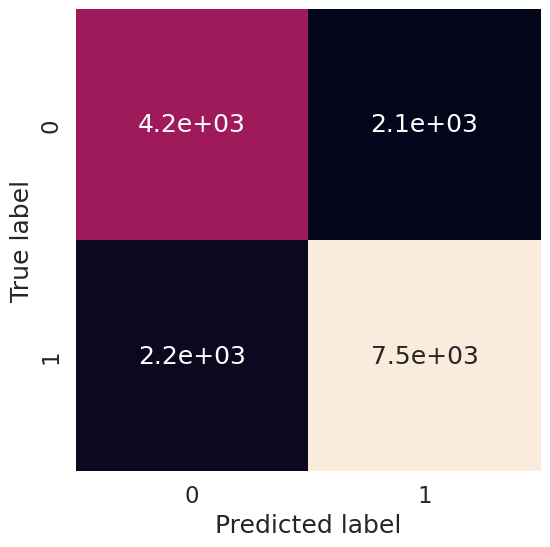

In [1053]:
import matplotlib.ticker as ticker
sns.set_theme(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap().
    """
    matrix = confusion_matrix(y_test, y_preds)
    print(matrix)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(
        matrix,
        annot=True, # Annotate the boxes
        cbar=False
    )
    plt.xlabel("Predicted label") # predictions go on the x-axis
    plt.ylabel("True label") # true labels go on the y-axis 

y_preds = model.predict(X_test)
plot_conf_mat(y_test, y_preds)

['membership_expire_date_day_of_year' 0.04644934538758167]
['remaining_days' 0.045437860829112706]
['is_auto_renew' 0.034722262926779233]
['transaction_date_day_of_year' 0.03323991165714133]
['membership_expire_date_month' 0.029473852597869946]
['total_hours' 0.02918997767909362]
['total_secs' 0.02883170785049967]
['num_unq' 0.027006268794331826]
['num_100' 0.026131050782178842]
['transaction_date_day' 0.025947285067170655]
['is_cancel' 0.024873120353386968]
['total_secs-2M' 0.024407186924957944]
['total_secs-1M' 0.02384370571958629]
['registration_init_time_day_of_year' 0.023486793536155876]
['num_25' 0.023174961093991944]
['num_unq-2M' 0.023131102072695385]
['num_100-1M' 0.022920662172619708]
['membership_expire_date_day' 0.02287493282184089]
['num_unq-1M' 0.02285043965583145]
['num_100-2M' 0.02254617300799737]
['num_25-1M' 0.021508682546943922]
['num_50' 0.021477120624339756]
['num_25-2M' 0.021047303779255642]
['payment_method_id_39' 0.01992857990136883]
['num_75' 0.0196470364281290

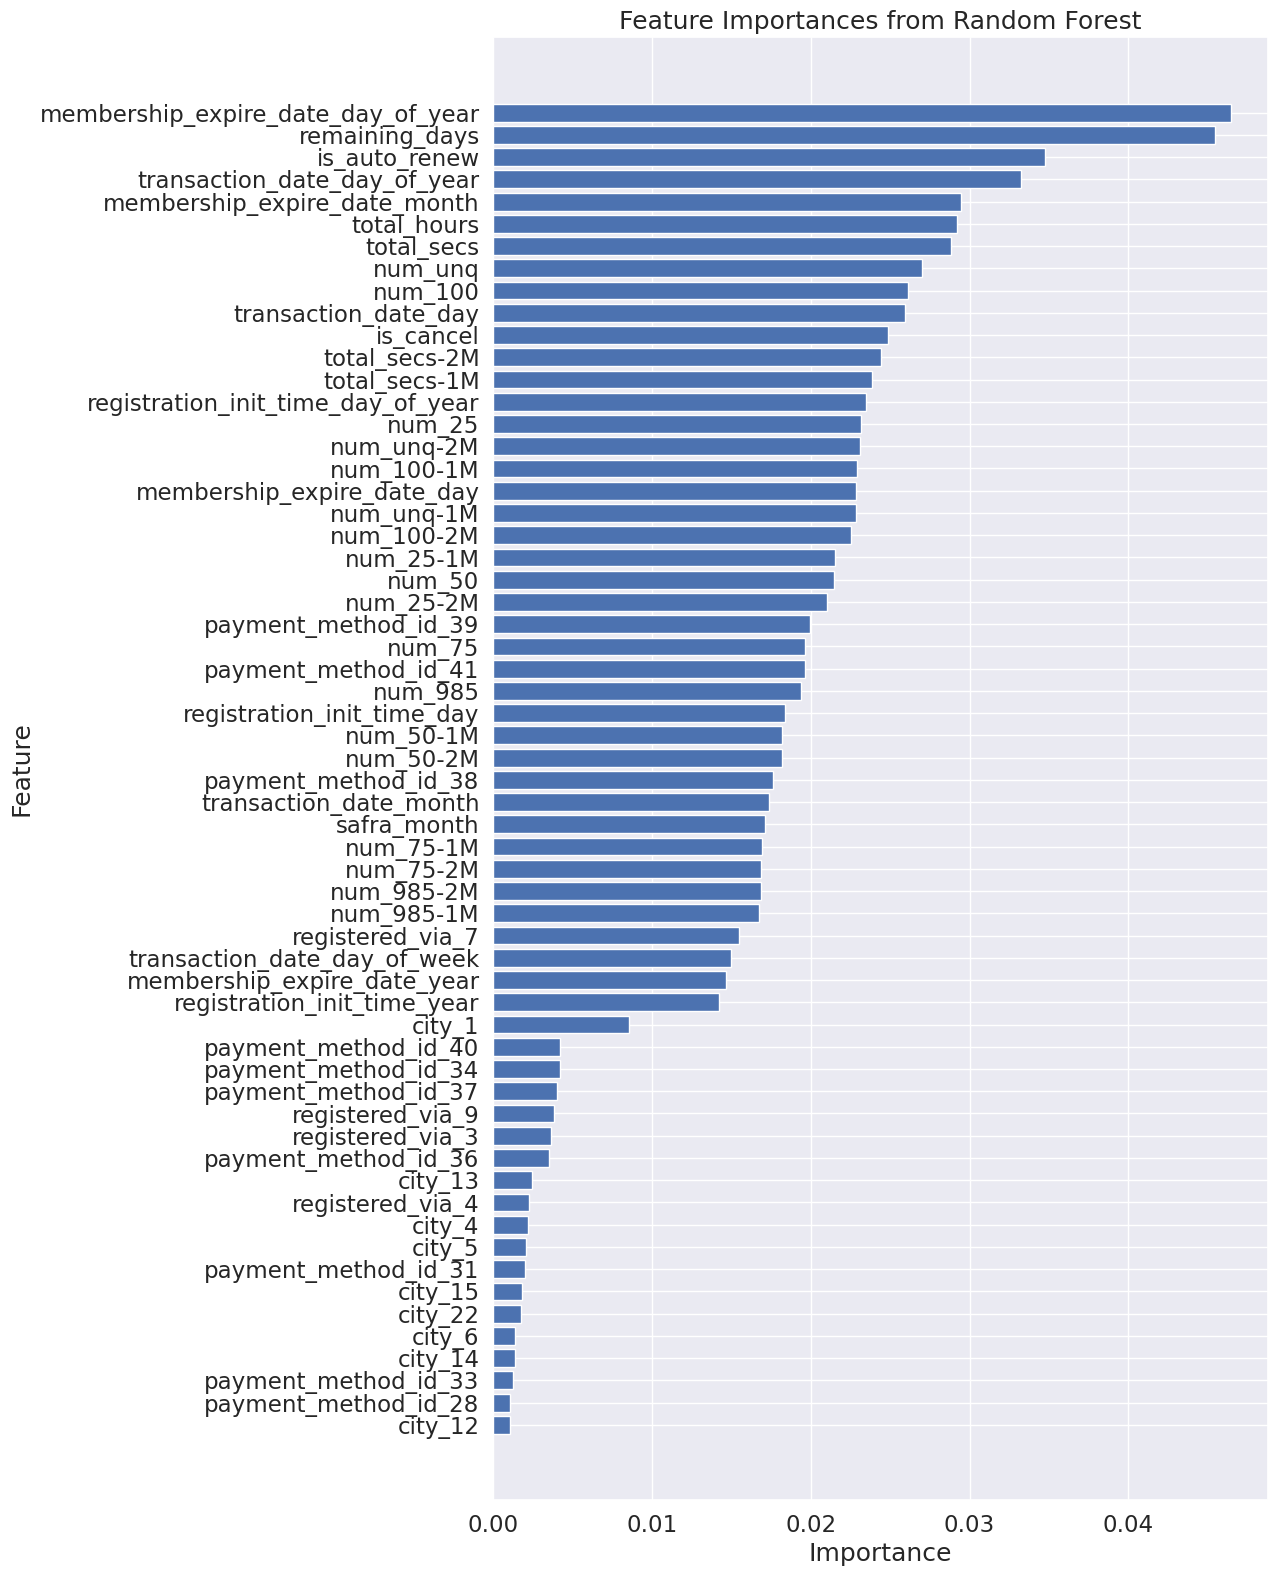

In [1050]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# feature_importances = feature_importances[:50]

for f in feature_importances.values:
    print(f)

feature_importances = feature_importances[feature_importances['Importance'] >= 0.001]

# Plot the feature importances
plt.figure(figsize=(10, 19))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

In [ ]:
import joblib
SAVED_MODEL_FILENAME = '../models/random_forest_model_' + datetime.now().strftime('%Y-%m-%d-%Hh-%Mm') + '.joblib'
joblib.dump(model, SAVED_MODEL_FILENAME)

['./random_forest_model_2025-03-20-20h-21m.joblib']

In [1052]:
loaded_model = joblib.load(SAVED_MODEL_FILENAME)
loaded_model

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='log2',
                       min_samples_split=10, random_state=42)